# Quickselect

Quickselect is similar to quicksort, but doesn't fully sort the data.
This is more efficient when it isn't necessary to sort the data to get a result.
For example, in order to calculate the median, it is only necessary to partition
data such that half the values are below the median and the other half is above it,
but these halves don't need to be fully sorted.
This notebook compares the [Floyd–Rivest](https://en.wikipedia.org/wiki/Floyd–Rivest_algorithm),
the [Hoare](https://en.wikipedia.org/wiki/Quickselect), and the python standard sort algorithm.
Note that all these algorithm modify the data in place.

My orginal interest in these `select` algorithms was due to sorting of points in the x-y plane
for use in triangulation.
One recursive Delaunay triangulation algorithm sorts the points by x and then y.
During construction this leads to long thin vertical triangles that are unlikely to be in the
final triangulation.
Perhaps a different sorting order could generate better initial triangles that could improve
the performance of the construction.
The recursive step divides the points into 2 halves, solves the sub-problems, and then merges the
results.
An improvement might be to divide the points along alternating axes.
In this case, it isn't necessary to fully sort the points.

Each algorithm implements the same interface and can be used to select the `kth` element in the data.
By default they select the median of all the data.

The Floyd-Rivest algorithm works quite well.

## Preliminaries

Import a few tools that are not significant to the algorithms.

In [1]:
from random import randint, random
from math import log, exp, sqrt

## Floyd-Rivest

Reported to be $O(n)$, it includes two meta-parameters: threshold and scale.
The default values of these parameters are reported to be optimal for performance.
The algorithm is modestly recursive. For large data sizes it selects a subset of
data to operate on. On return from the recursion, it continues the partitioning
of the data using the improved subset.
Note that this algorithm does not have a `random` selection element.

In [2]:
def frselect(a, left=None, right=None, index=None, threshold=600, scale=0.5):

    l = 0 if left == None else left
    r = len(a) - 1 if right == None else right
    k = r // 2 if index == None else index
    
    def select(a, l, r, k):
        while r > l:
            if r - l > threshold:
                n = r - l + 1
                i = k - l + 1
                z = log(n)
                s = scale * exp(2 * z / 3)
                sd = scale * sqrt(z * s * (n - s) / n)
                if i < n / 2:
                    sd = -sd
                nl = int(k - i * s/n + sd)
                if nl < l:
                    nl = l
                nr = int(k + (n - i) * s/n + sd)
                if nr > r:
                    nr = r
                select(a, nl, nr, k)

            t = a[k] 
            i = l
            j = r
            a[l], a[k] = a[k], a[l]
            if a[r] > t:
                a[r], a[l] = a[l], a[r]
            while i < j:
                a[i], a[j] = a[j], a[i]
                i = i + 1
                j = j - 1
                while a[i] < t:
                    i = i + 1
                while a[j] > t:
                    j = j - 1
            if a[l] == t:
                a[l], a[j] = a[j], a[l]
            else:
                j = j + 1
                a[j], a[r] = a[r], a[j]

            if j <= k:
                l = j + 1
            if k <= j:
                r = j - 1
        return

    select(a, l, r, k)

Check the results for correctness.

In [3]:
for _ in range(100):
    a = [random() for _ in range(10001)]
    k = len(a) // 2
    frselect(a)
    median = a[k]
    for i in range(k):
        if a[i] > median:
            raise AssertionError('bad low partition')
    for i in range(k, len(a)):
        if a[i] < median:
            raise AssertionError('bad high partition')
print('finished test')

finished test


# Hoare

Reported to be $O(n)$ with a worst case of $O(n^2)$.
This algorithm is not recursive, but includes a `random` component
in selecting the next possible pivot point.

In [4]:
def hselect(a, left=None, right=None, index=None):

    l = 0 if left == None else left
    r = len(a) - 1 if right == None else right
    k = r // 2 if index == None else index
    
    while r > l:
        p = randint(l, r)
        v = a[p]
        a[p], a[r] = a[r], a[p]
        j = l
        for i in range(l, r):
            if a[i] < v:
                a[j], a[i] = a[i], a[j]
                j += 1
        a[r], a[j] = a[j], a[r]
        if k < j:
            r = j - 1
        elif k > j:
            l = j + 1
        else:
            return

Check the results for correctness.

In [5]:
for _ in range(100):
    a = [random() for _ in range(10001)]
    k = len(a) // 2
    hselect(a)
    median = a[k]
    for i in range(k):
        if a[i] > median:
            raise AssertionError('bad low partition')
    for i in range(k, len(a)):
        if a[i] < median:
            raise AssertionError('bad high partition')
print('finished test')

finished test


# Python sort

A simple implementation.
Reported to be $O(n\ log\ n)$.

In [6]:
def sselect(a, left=None, right=None, k=None):
    a.sort()
    return

Check the results for correctness.

In [7]:
for _ in range(100):
    a = [random() for _ in range(10001)]
    k = len(a) // 2
    sselect(a)
    median = a[k]
    for i in range(k):
        if a[i] > median:
            raise AssertionError('bad low partition')
    for i in range(k, len(a)):
        if a[i] < median:
            raise AssertionError('bad high partition')
print('finished test')

finished test


# Results

Import timing and plotting tools.
Run each algorithm on a large array of varying lengths.
The times for each run are plotted and a line is drawn to the largest length.

In [8]:
from time import time
import matplotlib.pyplot as plt

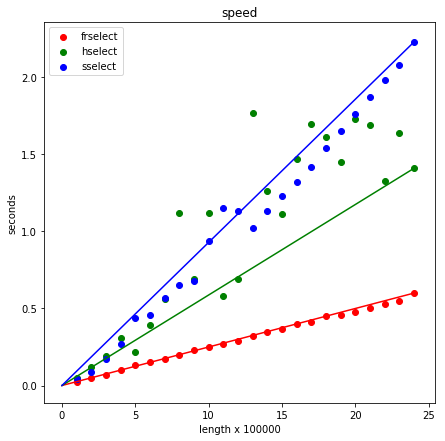

In [9]:
r = {}
funcs = {'frselect': frselect, 'hselect': hselect, 'sselect': sselect}
for select in funcs:
    d = {}
    for rng in range(1, 25):
        size = 100000 * rng
        a = [random() for _ in range(size)]
        stime = time()
        funcs[select](a)
        d[rng] = int((time() - stime) * 100) / 100
    r[select] = d

def plot(r, fsz=7):
    fig = plt.figure(figsize=[fsz, fsz])
    ax = fig.gca()
    ax.set_title('speed')
    plt.xlabel('length x 100000')
    plt.ylabel('seconds')
    cs = ['r', 'g', 'b', 'k']
    i = 0
    for select in r:
        timing = r[select]
        tm = max([k for k in timing])
        ax.scatter([k for k in timing], [timing[k] for k in timing], c=cs[i], label=select)
        plt.plot([0, tm], [0, timing[tm]], c=cs[i]) 
        i += 1
    legend = ax.legend(loc='upper left')
    plt.show()

plot(r)

# Remarks

For these larger data sets the python sort algorithm is the slowest.
The shape of the timing points suggest a worse than $O(n)$.
When operating an integer array, this algorithm worked considerably faster.
I think it is likely that this it implemented in `C` code.
The Hoare algorithm performs better but is considerably less consistent
is could be $O(n)$.
The Floyd-Rivest algorithm has the best performance, looks very
stable and appears to be $O(n)$ in practice.